In [5]:
import sys, csv, time, os
from pathlib import Path
import pandas as pd
import numpy as np
from pvlib.location import Location
from pvlib import solarposition 
from pvlib import irradiance 
from pvlib import clearsky, atmosphere
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.pvsystem import PVSystem  #
from pvlib import pvsystem 


#init args are as follows: date +"%Y-%m-%d", ic [00,12] 
### Wrapper's to define all the functions of each process and set up a huge human readable marker between that block and the function calls below

startTime = time.time()

### Crontab arguments (init args)

model = 'WRFENS'

### init dicts ###
#(lat, lon, elev, loc id)
counties_dict = {'Chittenden' : (44.496,-73.126, 340, 490),
'Lamoille' : (44.576, -72.592, 725, 491), 
'Washington' : (44.265,-72.496, 715, 492), 
'Windham' : (42.851, -72.568, 325, 493),  
'Caledonia' : (44.536,-72.029, 750, 494), 
'Orange' : (43.986,-72.135, 60, 495), 
'Windsor' : (43.523,-72.408, 500, 496), 
'Addison' : (44.032774,-73.228, 225, 497), 
'Bennington' : (42.895,-73.203, 675, 498), 
'Franklin' : (44.849,-72.937, 415, 499), 
'Rutland' : (43.604,-73.994, 550, 500), 
'GrandIsle' : (44.714,-73.313, 150, 501), 
'Essex' : (44.751,-71.630, 925, 502),
'Orleans' : (44.869,-72.240, 960, 503)}

Vermont = (-1, -1, -1, 17) # what does the vermont location csv hold?

plant_dict = {'Ground': (35,180),
            'Ground_Track': ('follows_sun','follows_sun'),
            'Roof_E': (30,90),
            'Roof_S': (30,180),
            'Roof_W': (30,270),
            'Roof_Commercial': (10,180),
            'Canopy': (0,180)}
            
#AC rating tuple positions loc_id == county : grnd mnt, grnd mnt track, roof e, roof s, roof w, roof com, canopy
ac_rating = {490: (39702, 4474, 4667, 9333, 4667, 12413, 160.0),
            491: (6023, 533, 438, 876, 438, 472, 116.0),
            492: (9159, 827, 1784, 3567, 1784, 1995, 44.8),
            493: (19542, 183, 798, 1596, 798, 1393, 0.0),
            494: (4313, 2217, 402, 803, 402, 398, 0.0),
            495: (19769, 1059, 848, 1695, 848, 2041, 7.6),
            496: (29392, 1731, 1664, 3327, 1664, 3926, 0.0),
            497: (33934, 7974, 1507, 3014, 1507, 781, 121.0),
            498: (15497, 119, 707, 1413, 707, 2939, 0.0),
            499: (13667, 887, 1096, 2192, 1096, 3014, 5.2),
            500: (30789, 653, 1283, 2565, 1283, 2868, 0.0),
            501: (1197, 90, 342, 684, 342, 324, 0.0),
            502: (708, 160, 89, 177, 89, 0, 0.0),
            503: (7958, 547, 369, 737, 369, 529, 0.0)}

# temp, wind speed, shortwave and their db multipliers
var_list = [(1,100),(4,100),(104,10)]
loc_ids =  [counties_dict[loc][-1] for loc in counties_dict]

plant_dict = {'Ground': [35,180],
            'Ground_Track': [35,180],  # ['follows_sun','follows_sun'] todo built out single tracker
            'Roof_E': [30,90],
            'Roof_S': [30,180],
            'Roof_W': [30,270],
            'Roof_Commercial': [10,180],
            'Canopy': [0,180]}
            
# AC rating tuple positions loc_id == county : grnd mnt, grnd mnt track, roof e, roof s, roof w, roof com, canopy
# AC rating describes the total watt limit of the aggregated inverters tied to the grid at each county.  
# We can assume that most inverters will be opperating at the industry standard of 95% efficency
# PVlib defines the inverter efficency for the call we will be using as 96.3% but allows room for customization

inverter_dc2ac = 0.96
inverter_ac2dc = 2 - inverter_dc2ac 
probabilities =  ['mean', 'P90', 'P75', 'P50', 'P25', 'P10']

string_time = pd.date_range(start="01-01-2020", end="01-01-2021", freq='h')


###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
def create_locobject():
    """
    populates a location object with the pvlib location object with data supplied by the counties_dict
    Input: (location_dict)
    Output: dictionary of location objects
    """
    location_obj = {}
    for county in counties_dict:
        location = Location(latitude=counties_dict[county][0],
                            longitude=counties_dict[county][1],
                            name = county, 
                            altitude=counties_dict[county][2], tz='EST')
        location_obj[counties_dict[county][-1]] = location
    print(f"location objects for {len(location_obj)} locations created")
    return location_obj

def get_solpos():
    """
    Keys off the `location_objects` dictionary and `fcast_times` and creates solar position data
    inputs: -none-
    outputs: LOC_ID keyed dict in dataframe format (on current version of pvlib)
    dataframes have columns of ['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation', 'azimuth', 'equation_of_time']
    """
    solpos = {} #data_dict <-in live version?
    for loc_id in loc_ids:
        solpos[loc_id] = loc_obj[loc_id].get_solarposition(times = string_time, temperature = 14) # temp is an optional argument and has little effect on the result
        print(f'location {loc_id} solpos created with shape of {solpos[loc_id].shape}')
    return solpos ##dict of dataframes          

def calc_clearsky(location_dict):
    """
    calculates the clearsky irradiance given the times for the forecast
    inputs:location_dict
    outputs: cs dict of clear sky irradiance keyed by location and 
    todo - update precipitable water and aod@700 to make for a more fitted prediction. otherwise this data can be stored on db
    """
    cs = {}
    for county in location_dict:
        loc_id = location_dict[county][-1]
        cs[loc_id] = {}
        precipitable_water = 1 # todo assumption move to times
        pressure = atmosphere.alt2pres(location_dict[county][2])
        # aod700nm = atmosphere.angstrom_aod_at_lambda(1.2, 1240, alpha_exponent, 700) #alternate function
        aod700 = 0.1 # todo assumption (move to times for dynamic)
        for idx, time in enumerate(string_time):
            
            dni_extra = irradiance.get_extra_radiation(pd.to_datetime(time))
            apparent_elevation = solpos[loc_id]['apparent_elevation'][idx]
            #returns an ordered dictionary
            od = clearsky.simplified_solis(apparent_elevation, aod700, precipitable_water,
                                          pressure, dni_extra)
            keys = list(od.keys())
            for key in keys:
                if idx == 0:
                    cs[loc_id][f'{key}'] = []
                val = od[key]
                cs[loc_id][f'{key}'].append(float(val))
        print(f'{loc_id} has {cs[loc_id].keys()}')
    print(f'cs for {len(cs)} locations complete')

    return cs
    

###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
###~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~###
string_time

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-31 15:00:00', '2020-12-31 16:00:00',
               '2020-12-31 17:00:00', '2020-12-31 18:00:00',
               '2020-12-31 19:00:00', '2020-12-31 20:00:00',
               '2020-12-31 21:00:00', '2020-12-31 22:00:00',
               '2020-12-31 23:00:00', '2021-01-01 00:00:00'],
              dtype='datetime64[ns]', length=8785, freq='H')

In [6]:
loc_obj = create_locobject()

solpos = get_solpos()

cs = calc_clearsky(counties_dict)

location objects for 14 locations created
location 490 solpos created with shape of (8785, 6)
location 491 solpos created with shape of (8785, 6)
location 492 solpos created with shape of (8785, 6)
location 493 solpos created with shape of (8785, 6)
location 494 solpos created with shape of (8785, 6)
location 495 solpos created with shape of (8785, 6)
location 496 solpos created with shape of (8785, 6)
location 497 solpos created with shape of (8785, 6)
location 498 solpos created with shape of (8785, 6)
location 499 solpos created with shape of (8785, 6)
location 500 solpos created with shape of (8785, 6)
location 501 solpos created with shape of (8785, 6)
location 502 solpos created with shape of (8785, 6)
location 503 solpos created with shape of (8785, 6)
490 has dict_keys(['ghi', 'dni', 'dhi'])
491 has dict_keys(['ghi', 'dni', 'dhi'])
492 has dict_keys(['ghi', 'dni', 'dhi'])
493 has dict_keys(['ghi', 'dni', 'dhi'])
494 has dict_keys(['ghi', 'dni', 'dhi'])
495 has dict_keys(['ghi',

In [9]:
ghi = cs[490]['ghi']

In [10]:
import matplotlib.pyplot as plt

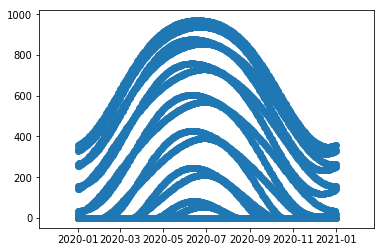

In [13]:
plt.scatter(x = string_time, y = ghi)

In [14]:
test_df = pd.DataFrame(ghi, index = string_time)

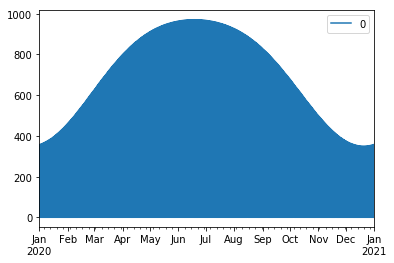

In [15]:
test_df.plot()

In [17]:
test_df.shape

(8785, 1)

In [18]:
test_df.to_csv('test.csv')

In [20]:
test_df.head(48)

,0
2020-01-01 00:00:00,0.000000
2020-01-01 01:00:00,0.000000
2020-01-01 02:00:00,0.000000
2020-01-01 03:00:00,0.000000
2020-01-01 04:00:00,0.000000
2020-01-01 05:00:00,0.000000
2020-01-01 06:00:00,0.000000
2020-01-01 07:00:00,0.000000
2020-01-01 08:00:00,0.000000
2020-01-01 09:00:00,0.000000
